In [1]:
# 1.2 Import Dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [2]:
# 1.3 Set GPU Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 1.4 Create Folder Structures
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [4]:
# 2.1 Untar Labelled Faces in the Wild Dataset
# Move LFW Images to the data/negative directory
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

In [5]:
# 2.2 Collect Positive and Anchor Classes
import uuid

cap = cv2.VideoCapture(1)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    if cv2.waitKey(1) & 0xFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    if cv2.waitKey(1) & 0xFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    cv2.imshow('Image Collection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [6]:
# 3. Load and Preprocess Images

# 3.1 Get Image Directories
anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, '*.jpg')).take(300)
positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, '*.jpg')).take(300)
negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, '*.jpg')).take(300)

In [7]:
# 3.2 Preprocessing - Scale and Resize
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return img

In [8]:
# 3.3 Create Labelled Dataset
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [9]:
# 3.4 Build Train and Test Partition
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

train_data = data.take(round(len(data) * .7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

test_data = data.skip(round(len(data) * .7))
test_data = test_data.take(round(len(data) * .3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)


In [10]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [11]:
# 4. Model Engineering

# 4.1 Build Embedding Layer
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    return Model(inputs=[inp], outputs=[d1], name='embedding')

embedding = make_embedding()

In [12]:
# 4.2 Build Distance Layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)


In [13]:
# 4.3 Make Siamese Model
def make_siamese_model():
    input_image = Input(name='input_img', shape=(100, 100, 3))
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

siamese_model = make_siamese_model()

In [14]:
# 5. Training

# 5.1 Setup Loss and Optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)


In [15]:
# 5.2 Establish Checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [16]:
# 5.3 Build Train Step Function
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

In [17]:
# 5.4 Build Training Loop
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS + 1):
        print(f'\n Epoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx + 1)
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [22]:
# 5.5 Train the model
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
9/9 [==============================] - 6s 473ms/step

 Epoch 2/50
9/9 [==============================] - 3s 347ms/step

 Epoch 3/50
9/9 [==============================] - 3s 348ms/step

 Epoch 4/50
9/9 [==============================] - 3s 359ms/step

 Epoch 5/50
9/9 [==============================] - 3s 370ms/step

 Epoch 6/50
9/9 [==============================] - 3s 382ms/step

 Epoch 7/50
9/9 [==============================] - 3s 392ms/step

 Epoch 8/50
9/9 [==============================] - 4s 401ms/step

 Epoch 9/50
9/9 [==============================] - 4s 403ms/step

 Epoch 10/50
9/9 [==============================] - 4s 404ms/step

 Epoch 11/50
9/9 [==============================] - 3s 424ms/step

 Epoch 12/50
9/9 [==============================] - 4s 405ms/step

 Epoch 13/50
9/9 [==============================] - 4s 405ms/step

 Epoch 14/50
9/9 [==============================] - 4s 405ms/step

 Epoch 15/50
9/9 [==============================] - 4s 406ms/step

 Ep

In [23]:
# 6. Evaluate Model

# 6.1 Import Metrics
from tensorflow.keras.metrics import Precision, Recall


In [24]:
# 6.2 Make Predictions
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 23ms/step


In [25]:
# 6.3 Calculate Metrics
m = Recall()
m.update_state(y_true, y_hat)
print('Recall:', m.result().numpy())

m = Precision()
m.update_state(y_true, y_hat)
print('Precision:', m.result().numpy())

Recall: 1.0
Precision: 1.0


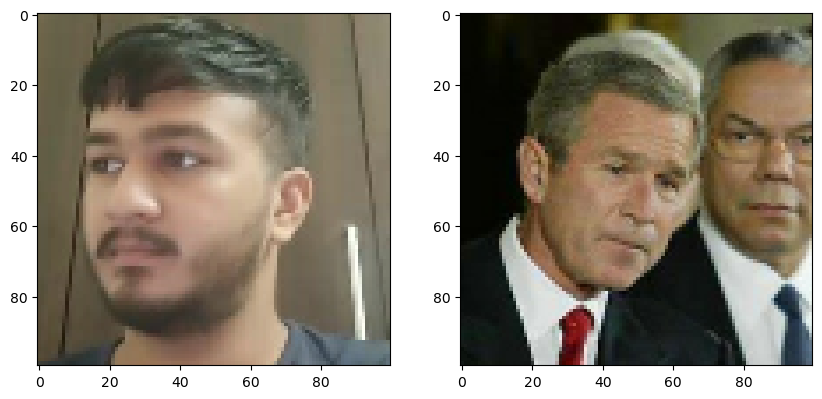

In [26]:
# 6.4 Viz Results
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(test_input[0])
plt.subplot(1, 2, 2)
plt.imshow(test_val[0])
plt.show()


In [27]:
# 7. Save Model
siamese_model.save('siamesemodel.h5')


In [28]:

# Reload model
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})


In [29]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 0s 145ms/step


array([[5.9275628e-08],
       [1.0000000e+00],
       [8.0943646e-10],
       [2.8444449e-08],
       [2.8706118e-08],
       [1.7193019e-10],
       [1.0000000e+00],
       [6.2543570e-08],
       [2.0822341e-07],
       [2.0462694e-06],
       [1.0000000e+00],
       [9.9998152e-01],
       [9.2973954e-05],
       [1.0000000e+00],
       [9.9975556e-01],
       [1.4619003e-06]], dtype=float32)

In [30]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [31]:
os.listdir(os.path.join('application_data', 'verification_images'))

['d2785db4-50f5-11ef-8e8c-fc349794977f.jpg',
 'd55855f6-50f5-11ef-acb1-fc349794977f.jpg',
 'e1314630-50f5-11ef-8791-fc349794977f.jpg',
 'e186b771-50f5-11ef-9e30-fc349794977f.jpg',
 'e19c6754-50f5-11ef-948b-fc349794977f.jpg',
 'e1fd42ff-50f5-11ef-89dd-fc349794977f.jpg',
 'e20bacbf-50f5-11ef-abba-fc349794977f.jpg',
 'e22ab936-50f5-11ef-b54b-fc349794977f.jpg',
 'e238fa15-50f5-11ef-b451-fc349794977f.jpg',
 'e25ad8db-50f5-11ef-9367-fc349794977f.jpg',
 'e269480f-50f5-11ef-89bd-fc349794977f.jpg',
 'e277d228-50f5-11ef-9296-fc349794977f.jpg',
 'e2a2896f-50f5-11ef-a9bb-fc349794977f.jpg',
 'e317c6d4-50f5-11ef-ae15-fc349794977f.jpg',
 'e325ef81-50f5-11ef-825c-fc349794977f.jpg',
 'e34e4744-50f5-11ef-af98-fc349794977f.jpg',
 'e35f134f-50f5-11ef-861a-fc349794977f.jpg',
 'e36d8b90-50f5-11ef-bfe0-fc349794977f.jpg',
 'e3830d6f-50f5-11ef-96a2-fc349794977f.jpg',
 'e393c886-50f5-11ef-8563-fc349794977f.jpg',
 'e463659d-50f5-11ef-a3f4-fc349794977f.jpg',
 'e4b023cf-50f5-11ef-855c-fc349794977f.jpg',
 'e4d18eb6

In [32]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [33]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\d2785db4-50f5-11ef-8e8c-fc349794977f.jpg
application_data\verification_images\d55855f6-50f5-11ef-acb1-fc349794977f.jpg
application_data\verification_images\e1314630-50f5-11ef-8791-fc349794977f.jpg
application_data\verification_images\e186b771-50f5-11ef-9e30-fc349794977f.jpg
application_data\verification_images\e19c6754-50f5-11ef-948b-fc349794977f.jpg
application_data\verification_images\e1fd42ff-50f5-11ef-89dd-fc349794977f.jpg
application_data\verification_images\e20bacbf-50f5-11ef-abba-fc349794977f.jpg
application_data\verification_images\e22ab936-50f5-11ef-b54b-fc349794977f.jpg
application_data\verification_images\e238fa15-50f5-11ef-b451-fc349794977f.jpg
application_data\verification_images\e25ad8db-50f5-11ef-9367-fc349794977f.jpg
application_data\verification_images\e269480f-50f5-11ef-89bd-fc349794977f.jpg
application_data\verification_images\e277d228-50f5-11ef-9296-fc349794977f.jpg
application_data\verification_images\e2a2896f-50f5-11ef-a9bb-fc3

In [80]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [85]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 26ms/step
False
1/1 [==============================] - 0s 25ms/step
True
1/1 [==============================] - 0s 21ms/step
True
1/1 [==============================] - 0s 21ms/step
True
1/1 [==============================] - 0s 19ms/step
True
1/1 [==============================] - 0s 23ms/step
True


In [87]:
np.squeeze(results)>0.5

array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [88]:
np.sum(np.squeeze(results)>0.5)

46